In [6]:
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
"""Lane line finding class."""

%matplotlib inline

In [61]:
import numpy as np
import cv2
import matplotlib.image as mpimg
import glob
from line import Line
import pickle
import os.path

class LaneLines():
    """The summary line for a class docstring should fit on one line."""

    def _init_perspective_transform_matrices(self):
        src = np.float32([[279.0, 674.0],
                          [531.0, 495.0],
                          [762.5, 495.0],
                          [1041.0, 674.0]])
        dst = np.float32([[279.0, 674.0],
                          [279.0, 495.0],
                          [1041.0, 495.0],
                          [1041.0, 674.0]])
        self._perspective_transform = cv2.getPerspectiveTransform(src, dst)
        self._perspective_inverse = cv2.getPerspectiveTransform(dst, src)

    def _convert_to_gray(self, img):
        if len(img.shape) > 2:
            channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
            if (channel_count == 3):
                return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        return img

    def _calibrate_camera_from_image(self, img, nx, ny, objpoints, imgpoints):
        objp = np.zeros((ny * nx, 3), np.float32)
        objp[:, :2] = np.mgrid[0:nx, 0:ny].T.reshape(-1, 2)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        shape = gray.shape[::-1]
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
        if ret:
            objpoints.append(objp)
            imgpoints.append(corners)
            img = cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
            self.callibration_chess_boards.append(img)
        return shape

    def _init_calibrate_camera(self, calibration_image_path):
        pickle_file = "calibration_data.p"
        if (os.path.isfile(pickle_file)):
            calibration_data = pickle.load(open(pickle_file, "rb"))
            if (calibration_data):
                self._mtx = calibration_data["mtx"]
                self._dist = calibration_data["dist"]
                self._rvecs = calibration_data["rvecs"]
                self._tvecs = calibration_data["tvecs"]
                return

        nx = 9
        ny = 6

        objpoints = []
        imgpoints = []
        print(calibration_image_path)

        for file in glob.glob(calibration_image_path + '/*.jpg'):
            print(file)
            img = mpimg.imread(file)
            shape = self._calibrate_camera_from_image(
                img, nx, ny, objpoints, imgpoints)

        ret = cv2.calibrateCamera(
            objpoints, imgpoints, shape, None, None)
        if(ret[0]):
            print("Successfully Calibrated Camera")
            self._mtx = ret[1]
            self._dist = ret[2]
            self._rvecs = ret[3]
            self._tvecs = ret[4]
            calibration_data = {"mtx": self._mtx,
                                "dist": self._dist,
                                "rvecs": self._rvecs,
                                "tvecs": self._tvecs}
            pickle.dump(calibration_data, open(pickle_file, "wb"))

        else:
            print("Failed to Calibrate Camera")

    def _build_gradients_for_source(self):
        self._sobelx = cv2.Sobel(self.source_channel, cv2.CV_64F,
                                 1, 0, ksize=self._sobel_x_kernel)
        self._sobely = cv2.Sobel(self.source_channel, cv2.CV_64F,
                                 0, 1, ksize=self._sobel_x_kernel)
        # build X gradient
        self._build_grad_x()
        self._build_grad_y()
        self._build_grad_dir()
        self._build_grad_mag()

    def _build_grad_x(self):
        # Apply threshold
        # Apply x or y gradient with the OpenCV Sobel() function
        # and take the absolute value
        abs_sobel = np.absolute(self._sobelx)
        # Rescale back to 8 bit integer
        scaled_sobel = np.uint8(255 * abs_sobel / np.max(abs_sobel))
        # Create a copy and apply the threshold
        self._grad_x_binary = np.zeros_like(scaled_sobel)
        # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
        self._grad_x_binary[(scaled_sobel >= self._grad_x_threshold[0]) &
                            (scaled_sobel <= self._grad_x_threshold[1])] = 1

    def _build_grad_y(self):
        # Apply threshold
        # Apply x or y gradient with the OpenCV Sobel() function
        # and take the absolute value
        abs_sobel = np.absolute(self._sobely)
        # Rescale back to 8 bit integer
        scaled_sobel = np.uint8(255 * abs_sobel / np.max(abs_sobel))
        # Create a copy and apply the threshold
        self._grad_x_binary = np.zeros_like(scaled_sobel)
        # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
        self._grad_x_binary[(scaled_sobel >= self._grad_y_threshold[0]) &
                            (scaled_sobel <= self._grad_y_threshold[1])] = 1

    def _build_grad_mag(self):
        # Calculate the gradient magnitude
        grad_mag = np.sqrt(self._sobelx**2 + self._sobely**2)
        # Rescale to 8 bit
        scale_factor = np.max(grad_mag) / 255
        grad_mag = (grad_mag / scale_factor).astype(np.uint8)

        # Create a binary image of ones where threshold is met, zeros otherwise
        self._grad_mag_binary = np.zeros_like(grad_mag)
        self._grad_mag_binary[(grad_mag >= self._mag_threshold[0]) &
                              (grad_mag <= self._mag_threshold[1])] = 1

    def _build_grad_dir(self):
        # Grayscale
        # Take the absolute value of the gradient direction,
        # apply a threshold, and create a binary image result
        abs_grad_dir = np.arctan2(np.absolute(self._sobely),
                                  np.absolute(self._sobelx))
        self._grad_dir_binary = np.zeros_like(abs_grad_dir)
        self._grad_dir_binary[(abs_grad_dir >= self._dir_threshold[0]) &
                              (abs_grad_dir <= self._dir_threshold[1])] = 1

    def write_image(self, name, img):
        """Write an image with the correct color space."""
        if len(img.shape) > 2:
            channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
            if (channel_count == 3):
                cv2.imwrite(name, cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        else:
            cv2.imwrite(name, img)

    def _weighted_img(self, img, initial_img, alpha=0.8, beta=1., epsilon=0.):
        """`img` is the image to overlay on top of initial img.

        `initial_img` should be the image before any processing.
        The result image is computed as follows:

        initial_img * alpha + img * beta + epsilon
        NOTE: initial_img and img must be the same shape!
        """
        return cv2.addWeighted(initial_img, alpha, img, beta, epsilon)

    def _draw_lines_between_points(self,
                                   shape,
                                   points,
                                   color=[255, 0, 0],
                                   thickness=10):
        """Draw `lines` on `img` with `color` and `thickness`."""
        img = np.zeros(shape, dtype=np.uint8)
        for idx in range(len(points) - 1):
            cv2.line(img, tuple(points[idx]), tuple(
                points[idx + 1]), color, thickness)
        return img

    def _prepare_img(self):
        undist = cv2.undistort(self.source_img, self._mtx,
                               self._dist, None, self._mtx)
        self.warped = cv2.warpPerspective(undist,
                                          self._perspective_transform,
                                          self.img_size,
                                          flags=cv2.INTER_LINEAR)
        # Crop out the bottom of the image where part of the car is visible.
        self.warped = self.warped[0:self.warped.shape[0] - 41:, :]
        self.hls = cv2.cvtColor(self.warped, cv2.COLOR_RGB2HLS)
        self.s_channel = self.hls[:, :, 2]
        self.gray = cv2.cvtColor(self.warped, cv2.COLOR_RGB2GRAY)
        # Changes this to different sources to try different channels etc.
        self.source_channel = self.s_channel
        # Apply each of the thresholding functions
        self._build_gradients_for_source()

        self.binary_warped = np.zeros_like(self.source_channel, np.int8)
        self.binary_warped[
            ((self._grad_x_binary == 1) &
             (self._grad_y_binary == 1)) |
            ((self._grad_mag_binary == 1) &
             (self._grad_dir_binary == 1))] = 1

    def process_image(self, img):
        """Process image and return image with Lane Line drawn."""
        self.source_img = img
        self.img_width = img.shape[1]
        self.img_height = img.shape[0]
        self.img_size = (self.img_width, self.img_height)

        self._prepare_img()
        # Take a histogram of the bottom half of the image
        self.histogram = np.sum(
            self.binary_warped[self.binary_warped.shape[0] // 2:, :], axis=0)
        # Create an output image to draw on and  self.visualize the result
#         self.binary_warped *= 255
        single_channel = self.binary_warped
        self.lane_find_visualization = np.dstack(
            (single_channel * 255, single_channel *255, single_channel *255)).astype(np.uint8)

        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        midpoint = np.int(self.histogram.shape[0] / 2)
        leftx_base = np.argmax(self.histogram[:midpoint])
        rightx_base = np.argmax(self.histogram[midpoint:]) + midpoint

        # Choose the number of sliding windows
        nwindows = 9
        # Set height of windows
        window_height = np.int(self.binary_warped.shape[0] / nwindows)
        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = self.binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Current positions to be updated for each window
        leftx_current = leftx_base
        rightx_current = rightx_base
        # Set the width of the windows +/- margin
        margin = 100
        # Set minimum number of pixels found to recenter window
        minpix = 50
        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []

        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = self.binary_warped.shape[0] - \
                (window + 1) * window_height
            win_y_high = self.binary_warped.shape[0] - window * window_height
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin
            # Draw the windows on the visualization image

            cv2.rectangle(self.lane_find_visualization,
                          (win_xleft_low, win_y_low),
                          (win_xleft_high, win_y_high),
                          (0, 255, 0),
                          2)
            cv2.rectangle(self.lane_find_visualization,
                          (win_xright_low, win_y_low),
                          (win_xright_high, win_y_high),
                          (0, 255, 0),
                          2)
            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) &
                              (nonzeroy < win_y_high) &
                              (nonzerox >= win_xleft_low) &
                              (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) &
                               (nonzeroy < win_y_high) &
                               (nonzerox >= win_xright_low) &
                               (nonzerox < win_xright_high)).nonzero()[0]
            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)
            # If you found > minpix pixels,
            # recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

        # Concatenate the arrays of indices
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)

        # Extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds]
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]

        # Fit a second order polynomial to each
        if (len(rightx) == 0 or len(leftx) == 0):
            return img

        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)

        # Generate x and y values for plotting
        ploty = np.linspace(
            0, self.binary_warped.shape[0] - 1, self.binary_warped.shape[0])
        left_fitx = left_fit[0] * ploty**2 + left_fit[1] * ploty + left_fit[2]
        right_fitx = right_fit[0] * ploty**2 + \
            right_fit[1] * ploty + right_fit[2]

        self.lane_find_visualization[nonzeroy[left_lane_inds],
                                      nonzerox[left_lane_inds]] = [255, 0, 0]
        self.lane_find_visualization[nonzeroy[right_lane_inds],
                                      nonzerox[right_lane_inds]] = [0, 0, 255]
        np.clip(right_fitx, 0, self.binary_warped.shape[1] - 1, out=right_fitx)
        np.clip(left_fitx, 0, self.binary_warped.shape[1] - 1, out=left_fitx)
        
        self.lane_find_visualization[ploty.astype(int), right_fitx.astype(int)] = [255, 255, 0]
        self.lane_find_visualization[ploty.astype(int), left_fitx.astype(int)] = [255, 255, 0]
        
        warp_zero = np.zeros_like(self.binary_warped).astype(np.uint8)
        color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

        # Recast the x and y points into usable format for cv2.fillPoly()
        pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        pts_right = np.array(
            [np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
        pts = np.hstack((pts_left, pts_right))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))

        # Warp the blank back to original image space
        # using inverse perspective matrix (Minv)
        newwarp = cv2.warpPerspective(
            color_warp, self._perspective_inverse, (self.img_size))
        # Combine the result with the original image
        result = cv2.addWeighted(self.source_img, 1, newwarp, 0.3, 0)
        return result

    def __init__(self, calibration_image_path):
        """Constructor."""
        # Set to the image currently being processed
        self._img = None

        # perspective transform matrix
        self._perspective_transform = None

        # perspective transform inverse matrix
        self._perspective_inverse = None

        # threshold values for the gradient in the X direction
        self._grad_x_threshold = (46, 82)
        self._sobel_x_kernel = 9
        # threshold values for the gradient in the Y direction
        self._grad_y_threshold = (14, 166)
        self._sobel_y_kernel = 9

        # threshold values for the gradient magnitude
        self._mag_threshold = (17, 255)
        # threshold values for the gradient direction in rads
        self._dir_threshold = (0.0, 0.47123889803846897)

        self._grad_x_binary = None
        self._grad_y_binary = None
        self._grad_mag_binary = None
        self._grad_dir_binary = None

        self.right_lane_line = Line()
        self.left_lane_line = Line()
        
        # Camera Calibration support
        self._calibration_mtx = None
        self._calibration_dist = None
        self._calibration_rvecs = None
        self._calibration_tvecs = None
        self.callibration_chess_boards = []
        
        # Image processing
        self.gray = None
        self.source_channel = None
        
        self.warped = None
        self.binary_warped = None
        self.lane_find_visualization = None
        self.histogram = None
        
        self._init_perspective_transform_matrices()
        self._init_calibrate_camera(calibration_image_path)


# lanes = LaneLines('camera_cal')
# img = mpimg.imread("test_images/test1.jpg")
# output_img = lanes.process_image(img)
# lanes.write_image("output_image.jpg", output_img)


test_images/test6.jpg


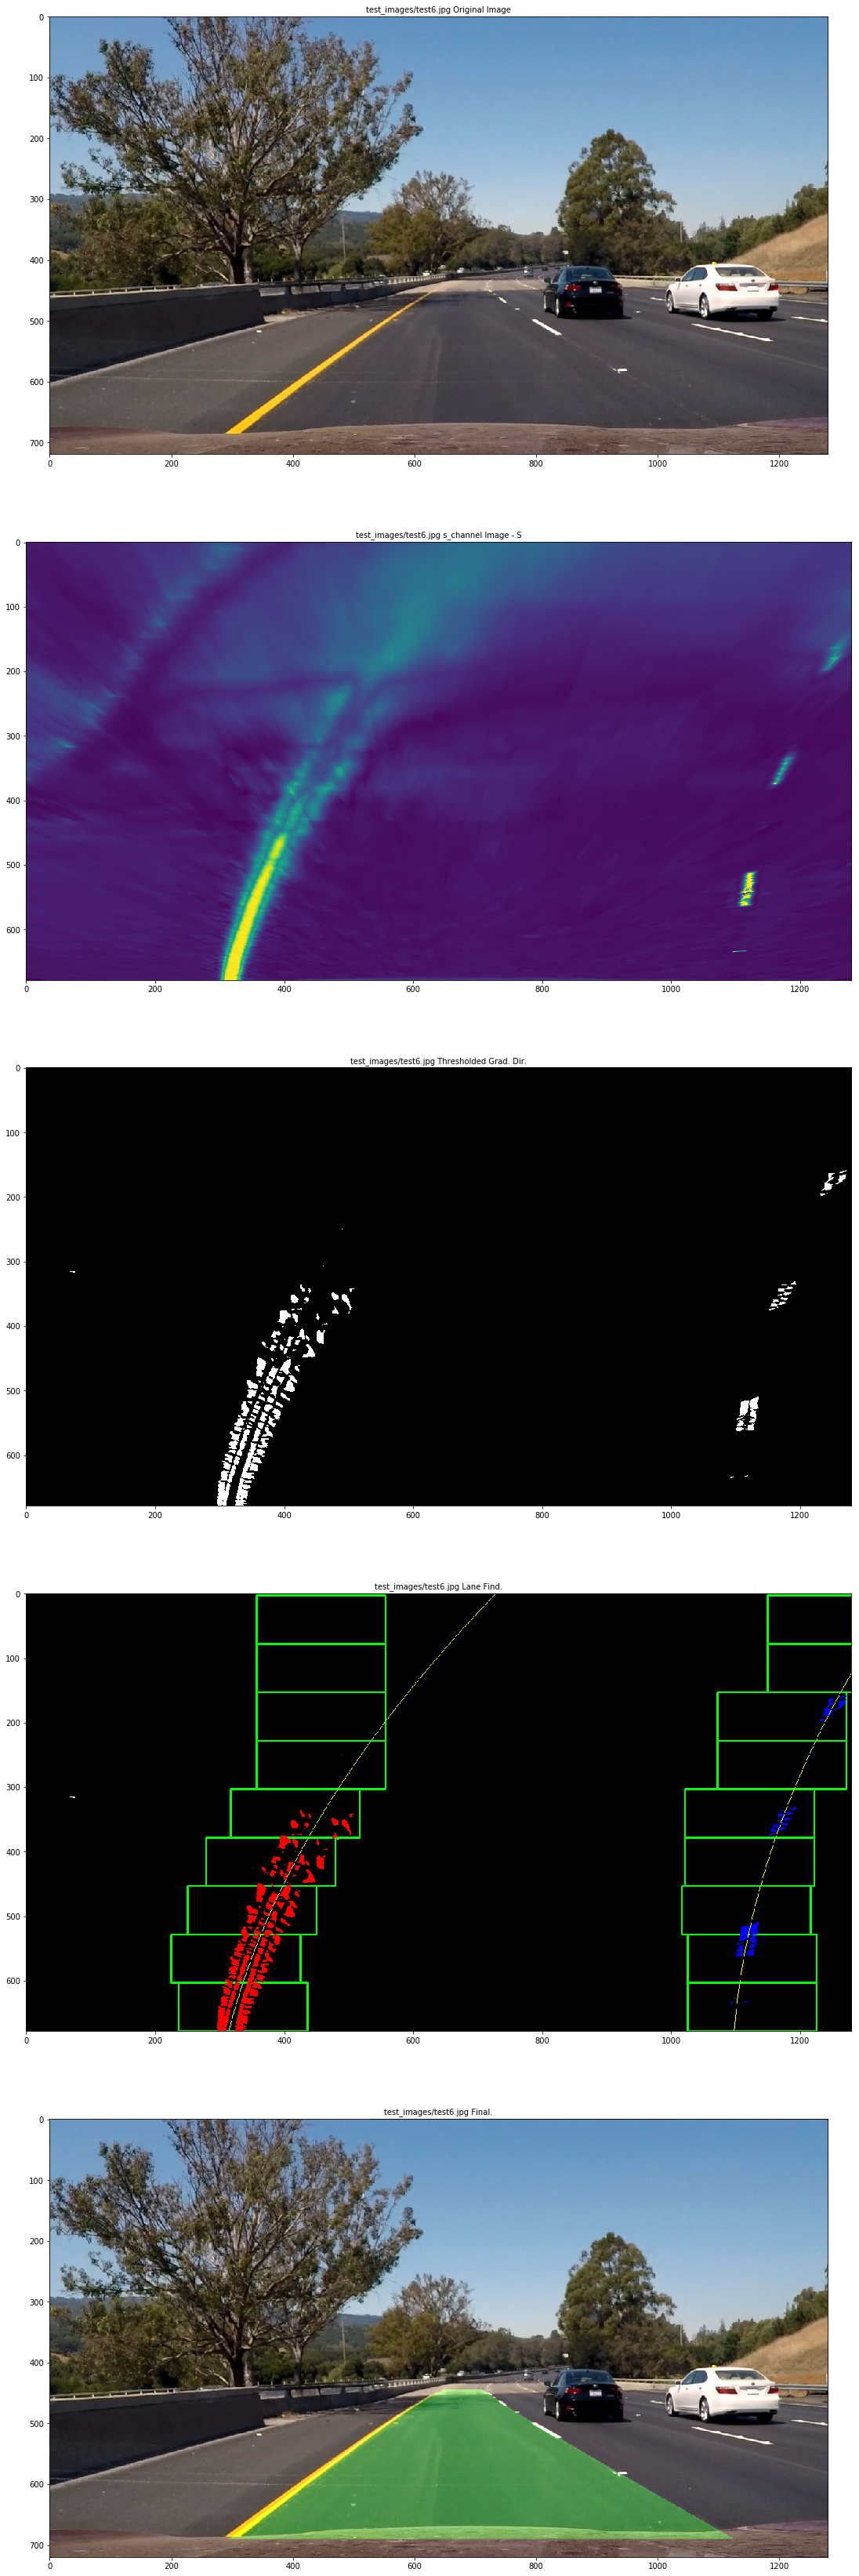

In [62]:
lanes = LaneLines('camera_cal')
for file in glob.glob('test_images/*test*.jpg'):
    print (file)
    img = mpimg.imread(file)
    final = lanes.process_image(img)
    f, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1, figsize=(50, 50))

    ax1.imshow(img)
    ax1.set_title(file + ' Original Image', fontsize=10)

    ax2.imshow(lanes.source_channel)
    ax2.set_title(file + ' s_channel Image - S', fontsize=10)

    ax3.imshow(lanes.binary_warped, cmap='gray')
    ax3.set_title(file + ' Thresholded Grad. Dir.', fontsize=10)

    ax4.imshow(lanes.lane_find_visualization)
    ax4.set_title(file + ' Lane Find.', fontsize=10)

    ax5.imshow(final)
    ax5.set_title(file + ' Final.', fontsize=10)

    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    break
    